In [1]:
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This notebook explores the 2023 my health my survey from https://datamillnorth.org/dataset/emd7m/my-health-my-school-survey. The notebook is broken down into the following sections:

1. Loading the Data - covers loading the data and working with multiindex columns which can be tricky.
2. Explore the text data in the columns - presents some ways to extract themes and topics from the very long columns names.
3. Explore Eating Habbits - Explores data on students' eating habbits in some detail.
4. Quick Starting Points - Briefly covers a few starting points that can be explored further.

We encourage you to find things in the data that you want to explore.

## 1. Loading the Data

In this notebook, we will only look at the 2023 data. Loading the data is not straight forward since the header of the CSV file is contained within the first two rows not just the first row. This means we have to work with Pandas' multiindex object which can be tricky.

Load the data ensuring the first two rows are treated as headers and `low_memory=False` to help ensure the correct data types are inferred.

In [34]:
path = "MHMS 20220901 - 20230831.csv"
df = pd.read_csv(path, header=[0, 1], low_memory=False)

# Display the first 5 rows and first 5 columns
df.iloc[:5, :5]

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0
,hashed_id,school_classification_list,school_local_authority_filter_classification,questionnaire_login_year_group_name,"As you are filling in this survey today, which of these would you use to describe your gender?"
0,'f995',Primary,Leeds,Year 5,Boy / Male
1,'49048',Primary,Leeds,Year 5,Girl / Female
2,'37bfc',Primary,Leeds,Year 5,Boy / Male
3,'610bdf',Secondary,National,Year 9,Girl / Female
4,'08514',Secondary,National,Year 9,Boy / Male


The second row of the header has been parsed correctly, the first row has not. All values in the first header row start with `Unnamed` which is Pandas' default behaviour when it encounters empty column names. For simplicity, I will now refer to the first row of the header as `header_1` and the second row as `header_2`.

Assign the name `header_1` and `header_2` to each level of the header. This is purely to make our code more readable.

In [3]:
df.columns.names = ["header_1", "header_2"]

The values in `header_1` and `header_2` can be accessed using the `get_level_values` method.

In [4]:
print(df.columns.get_level_values("header_1").tolist()[:5])
print(df.columns.get_level_values("header_2").tolist()[:5])

['Unnamed: 0_level_0', 'Unnamed: 1_level_0', 'Unnamed: 2_level_0', 'Unnamed: 3_level_0', 'Unnamed: 4_level_0']
['hashed_id', 'school_classification_list', 'school_local_authority_filter_classification', 'questionnaire_login_year_group_name', 'As you are filling in this survey today, which of these would you use to describe your gender?']


Find the names in `header_1` that do not start with `Unnamed`.

In [5]:
header_1 = df.columns.get_level_values("header_1")

# Display the first 10 names in header_1 that do not start with 'Unnamed'
header_1[~header_1.str.startswith("Unnamed")][:10]

Index(['In a normal week, how often do you have the following (this means not just a snack or a drink)?',
       'On a normal day, how many portions of the following do you have?',
       'How much do you agree or disagree with the following statements?',
       'How many minutes a week are you physically active for?',
       'In the last four weeks, not through school/college, which of the following activities have you done?',
       'Does anything stop you from taking part in physical activities?',
       'In the last 12 months, what sports/activities have you done in PE lessons?',
       'Has PE encouraged you to do any of the following '.?',
       'What after-school club(s) would you like school to offer?',
       'In the last 12 months, what sports club(s) have you attended outside of school?'],
      dtype='object', name='header_1')

It appears that the none missing values in `header_1` should be applied to all columns to the right until the next none missing value. For example, display the columns 16 through 26.

It appears that values in `header_1` that do not start with `Unnamed` should be applied to all columns to the right until the next value that does not start with `Unnamed`. This can be seen more clearly by looking at columns 16 through 26.

In [6]:
df.iloc[:5, 16:26]

header_1,"On a normal day, how many portions of the following do you have?",Unnamed: 17_level_0,Unnamed: 18_level_0,Unnamed: 19_level_0,Unnamed: 20_level_0,Unnamed: 21_level_0,Unnamed: 22_level_0,How much do you agree or disagree with the following statements?,Unnamed: 24_level_0,Unnamed: 25_level_0
header_2,"Sweetened drinks (e.g. Pepsi, fruit juice)",Fruit & vegetables (can include up to one medium glass of fruit juice),"Snacks (crisps, chocolate bar, packet of sweets, biscuits)","Unsweetened drinks (e.g. milk, water)","High energy drinks (e.g. Red Bull, Monster)",How often do you brush your teeth?,How often do you visit the dentist?,I like the food provided by my school/college and it tastes nice,"At this school/college, I have enough time to eat my lunch",Pupils/students behave well in the dining area
0,5 or more,5 or more,5 or more,5 or more,5 or more,Every day,Twice a year or more,Not sure,Not sure,Not sure
1,NaN,1,2,5 or more,NaN,Every day,Once a year for a check up,Not sure,Agree,Not sure
2,1,2,2,2,NaN,Every day,Once a year for a check up,Agree,Agree,Disagree
3,1,5 or more,2,1,NaN,Every day,Twice a year or more,Agree,Agree,Agree
4,NaN,3,1,5 or more,NaN,Every day,Once a year for a check up,Not sure,Agree,Agree


The value *"On a normal day, how many portions of the following do you have?"* in `header_1` applies to the following values in `header_2`:

* *"Sweetened drinks (e.g. Pepsi, fruit juice)"*
* *"Fruit & vegetables (can include up to one medium glass of fruit juice)"*
* *"Snacks (crisps, chocolate bar, packet of sweets, biscuits)"*
* *"Unsweetened drinks (e.g. milk, water)"*
* *"High energy drinks (e.g. Red Bull, Monster)"*

But it does not apply to *"How often do you brush your teeth?"* and *"How often do you visit the dentist"*. To avoid having to manually rename all values that start with `Unnamed: `, we will work under the that assumption values in `header_1` apply to all columns to right until the next none empty value in `header_1`. You should revisit this when you are doing your analysis to see if you can improve on this.

To replace all the missing values in `header_1`, we replace values that start with `Unnamed` with `NaN` then use the forward fill (`ffill`) to fill in the missing values.

In [7]:
new_column_names = df.columns.to_frame(index=False, name=["header_1", "header_2"]).copy()
new_column_names.loc[new_column_names["header_1"].str.startswith("Unnamed"), "header_1"] = np.nan
new_column_names.at[0, "header_1"] = "No Group"
new_column_names["header_1"] = new_column_names["header_1"].ffill()
new_column_names.head()

,header_1,header_2
0,No Group,hashed_id
1,No Group,school_classification_list
2,No Group,school_local_authority_filter_classification
3,No Group,questionnaire_login_year_group_name
4,No Group,"As you are filling in this survey today, which..."


Replace the column names in the original dataframe with the new column names.

In [8]:
df.columns = pd.MultiIndex.from_frame(new_column_names)
df.iloc[:5, :5]

header_1  No Group                             \
header_2 hashed_id school_classification_list   
0           'f995'                    Primary   
1          '49048'                    Primary   
2          '37bfc'                    Primary   
3         '610bdf'                  Secondary   
4          '08514'                  Secondary   

header_1                                               \
header_2 school_local_authority_filter_classification   
0                                               Leeds   
1                                               Leeds   
2                                               Leeds   
3                                            National   
4                                            National   

header_1                                      \
header_2 questionnaire_login_year_group_name   
0                                     Year 5   
1                                     Year 5   
2                                     Year 5   
3                                     Year 9   
4                                     Year 9   

header_1                                                                                                 
header_2 As you are filling in this survey today, which of these would you use to describe your gender?  
0                                                Boy / Male                                              
1                                             Girl / Female                                              
2                                                Boy / Male                                              
3                                             Girl / Female                                              
4                                                Boy / Male

All of the work has put the dataframe in a form that is easier to work with in pandas. For example, we can now use the `xs` method to get all columns related to a particular value in `header_1`.

Use `xs` to get all the columns with `No Group` in `header_1`.

In [9]:
df.xs("No Group", axis=1, level="header_1").head()

header_2,hashed_id,school_classification_list,school_local_authority_filter_classification,questionnaire_login_year_group_name,"As you are filling in this survey today, which of these would you use to describe your gender?",How would you describe your sexual identity?,Which of these describes you?,"Do you have, or do you consider yourself to have, a disability?",Where do you live most of the time?,Do you have a free school meal?,Which of these describes you as a student?,Are you a...,"In a normal week, how often do you have breakfast (this means not just a snack or a drink)?","On a normal school/college day, where do you eat breakfast?"
0,'f995',Primary,Leeds,Year 5,Boy / Male,NaN,Black,No,I live with my parent(s)/carer(s),I don't know,NaN,NaN,Every day/Most Days (4-7 days a week),At my school's breakfast club
1,'49048',Primary,Leeds,Year 5,Girl / Female,NaN,White,No,I live with my parent(s)/carer(s),"No, I don't have a free school meal",NaN,NaN,Every day/Most Days (4-7 days a week),At home
2,'37bfc',Primary,Leeds,Year 5,Boy / Male,NaN,I prefer not to say,No,I live with my parent(s)/carer(s),"No, I don't have a free school meal",NaN,NaN,Every day/Most Days (4-7 days a week),At home
3,'610bdf',Secondary,National,Year 9,Girl / Female,Heterosexual,White,No,I live with my parent(s)/carer(s),"No, I don't have a free school meal",NaN,NaN,Every day/Most Days (4-7 days a week),At home
4,'08514',Secondary,National,Year 9,Boy / Male,Heterosexual,White,Yes,I live with my parent(s)/carer(s),"Yes, I have a free school meal",NaN,NaN,Some days (2-3 days a week),At home


This can also be done with a for loop.

In [10]:
columns = [col for col in df.columns if col[0] == "No Group"]
df[columns].head()

header_1  No Group                             \
header_2 hashed_id school_classification_list   
0           'f995'                    Primary   
1          '49048'                    Primary   
2          '37bfc'                    Primary   
3         '610bdf'                  Secondary   
4          '08514'                  Secondary   

header_1                                               \
header_2 school_local_authority_filter_classification   
0                                               Leeds   
1                                               Leeds   
2                                               Leeds   
3                                            National   
4                                            National   

header_1                                      \
header_2 questionnaire_login_year_group_name   
0                                     Year 5   
1                                     Year 5   
2                                     Year 5   
3                                     Year 9   
4                                     Year 9   

header_1                                                                                                 \
header_2 As you are filling in this survey today, which of these would you use to describe your gender?   
0                                                Boy / Male                                               
1                                             Girl / Female                                               
2                                                Boy / Male                                               
3                                             Girl / Female                                               
4                                                Boy / Male                                               

header_1                                               \
header_2 How would you describe your sexual identity?   
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                        Heterosexual   
4                                        Heterosexual   

header_1                                \
header_2 Which of these describes you?   
0                                Black   
1                                White   
2                  I prefer not to say   
3                                White   
4                                White   

header_1                                                                  \
header_2 Do you have, or do you consider yourself to have, a disability?   
0                                                        No                
1                                                        No                
2                                                        No                
3                                                        No                
4                                                       Yes                

header_1                                      \
header_2 Where do you live most of the time?   
0          I live with my parent(s)/carer(s)   
1          I live with my parent(s)/carer(s)   
2          I live with my parent(s)/carer(s)   
3          I live with my parent(s)/carer(s)   
4          I live with my parent(s)/carer(s)   

header_1                                       \
header_2      Do you have a free school meal?   
0                                I don't know   
1         No, I don't have a free school meal   
2         No, I don't have a free school meal   
3         No, I don't have a free school meal   
4              Yes, I have a free school meal   

header_1                                                          \
header_2 Which of these describes you as a student? Are you a...   
0                                               NaN          NaN   
1                                               NaN     

Find the most common values in `header_1`. This will tell us the values in `header_1` that cover the largest number of columns.

In [11]:
header_1_frequency = (
    df.columns
    .get_level_values("header_1")
    .value_counts()
    .reset_index()
)
header_1_frequency.head()

,header_1,count
0,How much useful information and learning have ...,48
1,How good do you think your school/college are ...,48
2,"Today, what are you worrying about most?",45
3,"If you felt worried during lockdown, what did ...",44
4,"To make sure you are safe and healthy, would y...",40


Print the entire string of the most common value in `header_1`.

In [12]:
header_1_frequency.at[0, "header_1"]

'How much useful information and learning have you had to help you understand the following things? (e.g. through lessons at school/college)'

This covers 48 columns. Find some of the columns that are covered by this value in `header_1`.

In [13]:
header_1_name = "How much useful information and learning have you had to help you understand the following things? (e.g. through lessons at school/college)"
selected_columns = [col for col in df.columns if col[0] == header_1_name]

# Display the first 5 rows and first 5 columns
df[selected_columns].iloc[:5, :5]

header_1 How much useful information and learning have you had to help you understand the following things? (e.g. through lessons at school/college)  \
header_2                                                                                                                    How to cope with a death   
0                      I have had enough useful information                                                                                            
1                                 I need better information                                                                                            
2                      I have had enough useful information                                                                                            
3                      I have had enough useful information                                                                                            
4                      I have had enough useful information                                                                                            

header_1                                                      \
header_2 Bullying (including online) and what to do about it   
0                      I have had enough useful information    
1                      I have had enough useful information    
2                      I have had enough useful information    
3                      I have had enough useful information    
4                      I have had enough useful information    

header_1                                            \
header_2 Risk of giving /accepting a lift in a car   
0                                              NaN   
1                                              NaN   
2                                              NaN   
3             I have had enough useful information   
4             I have had enough useful information   

header_1                                           \
header_2 Pressure/encouragement to commit a crime   
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                       I need better information   
4            I have had enough useful information   

header_1                                        
header_2                      Risks of alcohol  
0         I have had enough useful information  
1         I have had enough useful information  
2         I have had enough useful information  
3         I have had enough useful information  
4         I have had enough useful information

## 2. Exploring the text in the column headers

In the previous section we saw that the values in `header_1` and `header_2` can be very long making it very difficult to find common themes across the columns. In this section, we will explore the text in the headers and introduce some techniques for finding frequent words.

Extract some basic statistics from `header_1` and `header_2`.

In [14]:
print(f"Number of unique values in header_1: {df.columns.get_level_values('header_1').nunique()}")
print(f"Number of unique values in header_2: {df.columns.get_level_values('header_2').nunique()}")
print(f"Number of columns: {df.shape[1]}")

Number of unique values in header_1: 55
Number of unique values in header_2: 665
Number of columns: 898


We want to find frequent words in these headers which should indicate themes these in the dataset. A nice way to visualise this is with a word cloud; the larger the word, the more common it is.

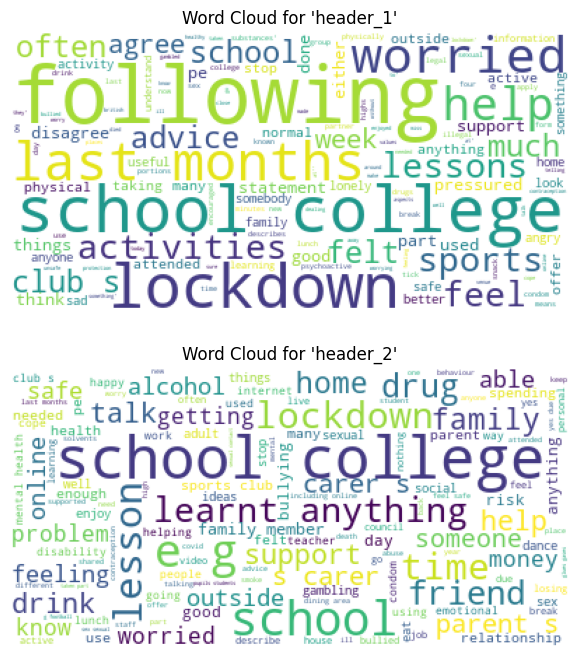

In [15]:
from wordcloud import WordCloud

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i, header in enumerate(["header_1", "header_2"]):
    names = df.columns.get_level_values(header).unique()
    text = " ".join(names).lower()
    
    word_cloud = WordCloud(background_color="white")
    word_cloud.generate(text)

    ax[i].imshow(word_cloud)
    ax[i].axis("off")
    ax[i].set_title(f"Word Cloud for '{header}'")

Some themes that jump out to me:

* Lockdown
* Sports/healthy eating
* Money
* Mental health and pressure.

There are are some word that do not tell us much. For example, the letters `e` and `g` are common but that is probably from the shorthand `e.g.`. Can these word clounds be improved by removing some of these uninteresting words?

Now let us find the columns that contain the word lockdown in `header_2`.

In [16]:
selected_columns = [col for col in df.columns if "lockdown" in col[1].lower()]

# Display the first 5 rows and first 8 columns
df[selected_columns].iloc[:5, :5]

header_1     Today, what are you worrying about most?  \
header_2 How has the lockdown affected your feelings?   
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   

header_1 What things made you feel better when you were worried during lockdown?  \
header_2                            I did not use anything to cope with lockdown   
0                                                       NaN                        
1                                                       NaN                        
2                                                       NaN                        
3                                                       NaN                        
4                                                       NaN                        

header_1                          \
header_2 During lockdown, I was:   
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

header_1                                                       During lockdown . . .  \
header_2 During lockdown, my experience of bullying (including online bullying) was'   
0                                                       NaN                            
1                                                       NaN                            
2                                                       NaN                            
3                                                       NaN                            
4                                                       NaN                            

header_1                                                       During lockdown'  
header_2 During lockdown, which of the following statements describes you . . .  
0                                                       NaN                      
1                                                       NaN                      
2                                                       NaN                      
3                                                       NaN                      
4                                                       NaN

The table above contains data on feelings and experiences during lockdown. Note that in `header_1`, the values `During lockdown. . .` and `During lockdown'` should perhaps be treated the same. You should explore to see if there are other values `header_1` or `header_2` that have the same problem. There is also a lot of missing data in the table above, you should see if there is any data for these columns.

# 3. Exploring Eating Habbits

In the previous section, we saw some techniques to find and extract common themes from the data. In this section we are going to dive a little deeper into the students' eating habbits. We start by looking at *"In a normal week, how often do you have the following (this means not just a snack or a drink)?"* from `header_1`.

Extract data assosciated with this value.

In [17]:
header_1 = "In a normal week, how often do you have the following (this means not just a snack or a drink)?"

selected_columns = [col for col in df.columns if col[0] == header_1]
df[selected_columns].head()

header_1 In a normal week, how often do you have the following (this means not just a snack or a drink)?  \
header_2                                                                                           Lunch   
0                      Everyday/Most Days (4-7 days a week)                                                
1                      Everyday/Most Days (4-7 days a week)                                                
2                      Everyday/Most Days (4-7 days a week)                                                
3                      Everyday/Most Days (4-7 days a week)                                                
4                      Everyday/Most Days (4-7 days a week)                                                

header_1                                        
header_2                   Evening meal/Dinner  
0         Everyday/Most Days (4-7 days a week)  
1         Everyday/Most Days (4-7 days a week)  
2         Everyday/Most Days (4-7 days a week)  
3         Everyday/Most Days (4-7 days a week)  
4         Everyday/Most Days (4-7 days a week)

This table contains information on the number of times the students get a proper lunch and dinner in a normal week.

Count the number of students that belong to each group.

In [18]:
df_meals = df[selected_columns]

# Drop 'header_1' to shorten to column names
df_meals.columns = df_meals.columns.droplevel("header_1")

df_meals = df_meals.value_counts().reset_index(name="Count")
df_meals

,Lunch,Evening meal/Dinner,Count
0,Everyday/Most Days (4-7 days a week),Everyday/Most Days (4-7 days a week),22243
1,Some days (2-3 days a week),Everyday/Most Days (4-7 days a week),3323
2,Everyday/Most Days (4-7 days a week),Some days (2-3 days a week),1287
3,Rarely/Never (1 day or less a week),Everyday/Most Days (4-7 days a week),647
4,Some days (2-3 days a week),Some days (2-3 days a week),643
5,Rarely/Never (1 day or less a week),Some days (2-3 days a week),250
6,Rarely/Never (1 day or less a week),Rarely/Never (1 day or less a week),202
7,Everyday/Most Days (4-7 days a week),Rarely/Never (1 day or less a week),197
8,Some days (2-3 days a week),Rarely/Never (1 day or less a week),168


Most students have lunch and dinner most days in the week but there are a concerning number of students who do not.

Let us visualise this data in a heatmap. To do this, we must pivot the dataframe so its index is the `Lunch` columns and its columns are the `Evening meal/Dinner` column.

In [19]:
tmp = df_meals.pivot(index="Lunch", columns="Evening meal/Dinner", values="Count")
tmp

Evening meal/Dinner,Everyday/Most Days (4-7 days a week),Rarely/Never (1 day or less a week),Some days (2-3 days a week)
Lunch,,,
Everyday/Most Days (4-7 days a week),22243,197,1287
Rarely/Never (1 day or less a week),647,202,250
Some days (2-3 days a week),3323,168,643


Now can plot the heatmap.

Text(0.5, 1.0, 'In a Normal Week, how often do Students have Lunch or Dinner?')

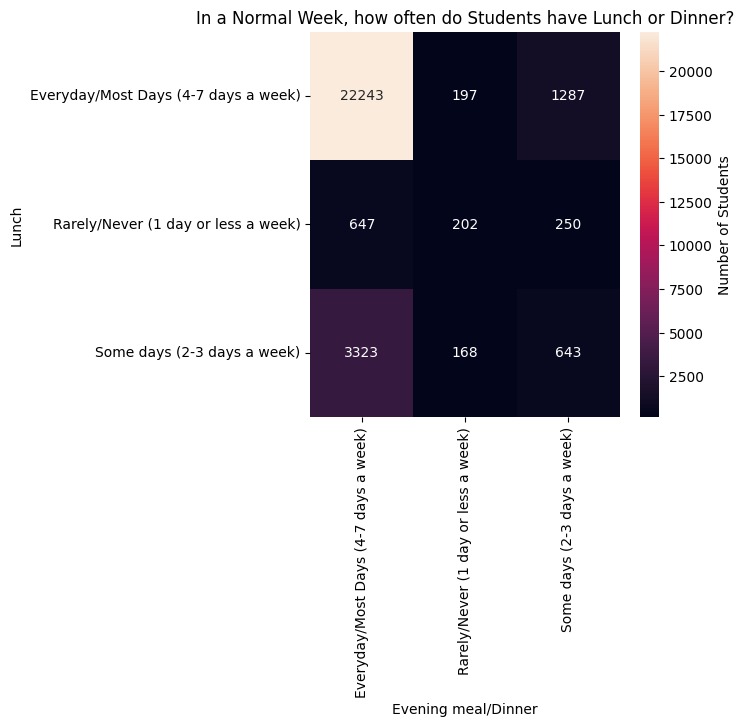

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(
    tmp,
    annot=True,
    fmt=".0f",  # Ensure the annotations are integers
    cbar_kws={"label": "Number of Students"}
)
ax.set_title("In a Normal Week, how often do Students have Lunch or Dinner?")

Over 1000 students get a proper lunch/dinner fewer than four times per week. Assuming the students are in school 5 days per week, there may be a problem with dining at school that is preventing students from getting at least 5 proper lunches per week. We have data on the opinions of students' on school dining under the header "How much do you agree or disagree with following statements?" in `header_1`.

In [21]:
header_1 = "How much do you agree or disagree with the following statements?"
df.xs(header_1, axis=1, level="header_1").head()

header_2,I like the food provided by my school/college and it tastes nice,"At this school/college, I have enough time to eat my lunch",Pupils/students behave well in the dining area,My school/college encourages me to drink water regularly,I can usually find a place to sit and eat my lunch in the dining area,I enjoy eating in my school/college dining area,Queuing time is short in the dining area,How often do you have breakfast each week (this means not just a snack or a drink)?,"How many snacks (crisps, chocolate bar, packet of sweets, biscuits) do you eat a day?",How many portions of fruit and vegetables do you eat a day (can include one medium glass of fruit juice)?,...,Does your school/college encourage you to drink water regularly?,How do you usually travel to college?,"How many minutes a day, do you usually spend sitting down watching TV/playing computer games/using the internet/using a mobile phone?",There are good things to do before and after school/college,There are good things to do at break times/lunch times,I enjoy going to school/college,My school/college is a caring place,My school/college helps me if I am worried or have a problem,There are staff in my school/college that I trust,I feel like I belong to my school/college community
0,Not sure,Not sure,Not sure,Not sure,Not sure,Not sure,Not sure,NaN,NaN,NaN,...,NaN,NaN,1 - 60 minutes (Up to 1 hour),Agree,Agree,Agree,Agree,Agree,Agree,Agree
1,Not sure,Agree,Not sure,Agree,Agree,Not sure,Not sure,NaN,NaN,NaN,...,NaN,NaN,61 - 120 minutes (1 hour 1 minute - 2 hours),Agree,Agree,Agree,Agree,Not sure,Agree,Not sure
2,Agree,Agree,Disagree,Agree,Agree,Agree,Disagree,NaN,NaN,NaN,...,NaN,NaN,61 - 120 minutes (1 hour 1 minute - 2 hours),Agree,Agree,Agree,Agree,Agree,Agree,Agree
3,Agree,Agree,Agree,Not sure,Agree,Agree,Not sure,NaN,NaN,NaN,...,NaN,NaN,61 - 120 minutes (1 hour 1 minute - 2 hours),Agree,Agree,Agree,Agree,Agree,Agree,Not sure
4,Not sure,Agree,Agree,Not sure,Agree,Agree,Not sure,NaN,NaN,NaN,...,NaN,NaN,121 - 180 minutes (2 hours 1 minute - 3 hours),Agree,Agree,Agree,Agree,Not sure,Agree,Agree


There are several columns related to school dining area and dinners. Extract these columns so we have a smaller dataframe to work with.

In [22]:
header_2 = {
    "I like the food provided by my school/college and it tastes nice",
    "At this school/college, I have enough time to eat my lunch",
    "Pupils/students behave well in the dining area",
    "I can usually find a place to sit and eat my lunch in the dining area",
    "Queuing time is short in the dining area",
    "I enjoy eating in my school/college dining area"
}
selected_columns = [col for col in df.columns if col[1] in header_2]

df_lunch = df[selected_columns]
df_lunch.head()

header_1 How much do you agree or disagree with the following statements?  \
header_2 I like the food provided by my school/college and it tastes nice   
0                                                  Not sure                 
1                                                  Not sure                 
2                                                     Agree                 
3                                                     Agree                 
4                                                  Not sure                 

header_1                                                             \
header_2 At this school/college, I have enough time to eat my lunch   
0                                                  Not sure           
1                                                     Agree           
2                                                     Agree           
3                                                     Agree           
4                                                     Agree           

header_1                                                 \
header_2 Pupils/students behave well in the dining area   
0                                              Not sure   
1                                              Not sure   
2                                              Disagree   
3                                                 Agree   
4                                                 Agree   

header_1                                                                        \
header_2 I can usually find a place to sit and eat my lunch in the dining area   
0                                                  Not sure                      
1                                                     Agree                      
2                                                     Agree                      
3                                                     Agree                      
4                                                     Agree                      

header_1                                                  \
header_2 I enjoy eating in my school/college dining area   
0                                               Not sure   
1                                               Not sure   
2                                                  Agree   
3                                                  Agree   
4                                                  Agree   

header_1                                           
header_2 Queuing time is short in the dining area  
0                                        Not sure  
1                                        Not sure  
2                                        Disagree  
3                                        Not sure  
4                                        Not sure

Since all of these columns are categorical, we can plot a simple bar plot to get a quick understanding of the responses to each of these questions. To avoid cluttering the page, we can incorporate a dropdown widget from the ipywidgets library to display the plot for each question one at a time. 

In [23]:
import ipywidgets as widgets
from ipywidgets import interact

lunch_questions = [
    "I like the food provided by my school/college and it tastes nice",
    "At this school/college, I have enough time to eat my lunch",
    "Pupils/students behave well in the dining area",
    "I enjoy eating in my school/college dining area",
    "I can usually find a place to sit and eat my lunch in the dining area",
    "Queuing time is short in the dining area",
    "I enjoy eating in my school/college dining area"
]

def lunch_plot(question):
    counts = df_lunch["How much do you agree or disagree with the following statements?"].groupby(question).size()
    counts.plot(kind='bar', stacked=True, )

lunch_widget = widgets.Dropdown(
    options = lunch_questions,
    description = 'Question:'
)

interact(lunch_plot, question = lunch_widget)

interactive(children=(Dropdown(description='Question:', options=('I like the food provided by my school/colleg…

<function __main__.lunch_plot(question)>

Plot a heat map showing the number of students that get less that 4 proper lunches per week and say that they do not enjoy dining eating in the school dining area.

Text(0.5, 23.52222222222222, 'How often do you have lunch (this means not just a snack or drink)?')

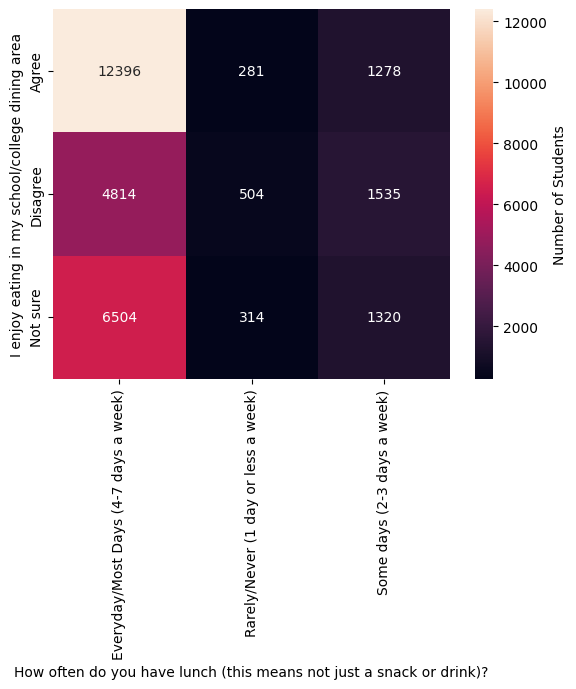

In [24]:
col1 = (
    "How much do you agree or disagree with the following statements?",
    "I enjoy eating in my school/college dining area",
)
col2 = (
    "In a normal week, how often do you have the following (this means not just a snack or a drink)?",
    "Lunch"
)
tmp = df[[col1, col2]].value_counts().reset_index(name="Count")
tmp = tmp.pivot(index=[tmp.columns[0]], columns=[tmp.columns[1]], values="Count")

fig, ax = plt.subplots()
sns.heatmap(
    tmp,
    annot=True,
    fmt=".0f",  # Ensure the annotations are integers
    cbar_kws={"label": "Number of Students"}
)
ax.set_ylabel(col1[1])
ax.set_xlabel("How often do you have lunch (this means not just a snack or drink)?")

Of the students who get 4 or more lunches per week, most say they enjoy eating in the dining area. However, of the students that get a proper lunch fewer than 4 days per week, the number of students who say they don't enjoy eating in the dining area is higher than those who say they are not sure or agree.

We want to know which columns affect whether a student enjoys eating in their school dining area. In other words, of the students who do not enjoy eating in the dining area what other opinions do they commonly have about the dining area? One way to do this is by looking at heatmaps for each column to see, for example, the number of students who did not enjoy eating in the school dining area and also felt they did not enough time to eat lunch. Another way to do this is by training a model to predict whether a student enjoys eating in the dining area and looking for the most important features in the model.

For simplicity, we are going to train a simple logistic regression model to predict whether a student will enjoy eating in the dining area. Logistic regression models only work on numerical data so we need to convert the strings in `df_lunch` to numbers.

In [25]:
df_lunch_numeric = df_lunch.replace({"Agree": 1, "Not sure": 0, "Disagree": -1})

# Again drop 'header_1' to make the column names shorter
df_lunch_numeric.columns = df_lunch_numeric.columns.droplevel("header_1")

# Remove rows where the target variable is missing
df_lunch_numeric = df_lunch_numeric.loc[~df_lunch_numeric["I enjoy eating in my school/college dining area"].isna(), :].copy()

/var/folders/4m/k8v4qbvs2qx5bygbcnt4nn240000gq/T/ipykernel_97555/4036847210.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_lunch_numeric = df_lunch.replace({"Agree": 1, "Not sure": 0, "Disagree": -1})


Split the dataset into `X` and `y` and plot the distribution of `y`.

<Axes: xlabel='I enjoy eating in my school/college dining area', ylabel='count'>

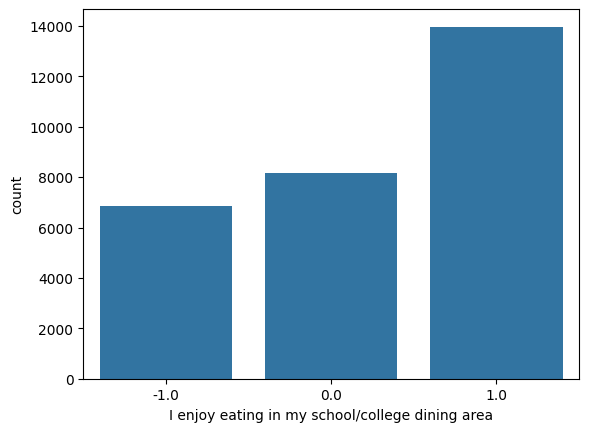

In [26]:
y_col = "I enjoy eating in my school/college dining area"
X = df_lunch_numeric.drop(columns=y_col)
y = df_lunch_numeric[y_col].copy()
sns.barplot(y.value_counts())

Most students have a value of 1 for *"I enjoy eating in my school/college dining area"*. In order to get a balanced data for our predictions, we will combine the -1 and 0 labels.

<Axes: xlabel='I enjoy eating in my school/college dining area', ylabel='count'>

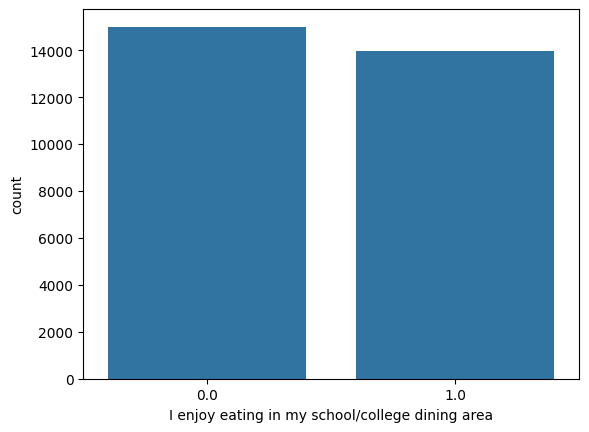

In [27]:
y = y.replace({-1.0: 0.0})
sns.barplot(y.value_counts())

Now we are ready to train our logistic regression model. We split our data in a training a test set. We train it on the training data and evaluate its performance on the test data which it has never seen before.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0.0), y)

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

accuracy_train = (y_train_pred == y_train).mean()
accuracy_test = (y_test_pred == y_test).mean()

print("Train accuracy: ", accuracy_train)
print("Test accuracy:  ", accuracy_test)

Train accuracy:  0.709039027982327
Test accuracy:   0.7110313406047218


The train and test accuracies are quite similar suggesting we are not overfitting the data. The model is better that just randomly selecting 0 and 1 (50%) but it is not amazing performance. However, the thing we are most interested in is the features that are most important in making these predictions.

We can get a sense of the most important features by looking at the models parameters with largest magnitudes. Visualise these magnitudes with a bar chart.

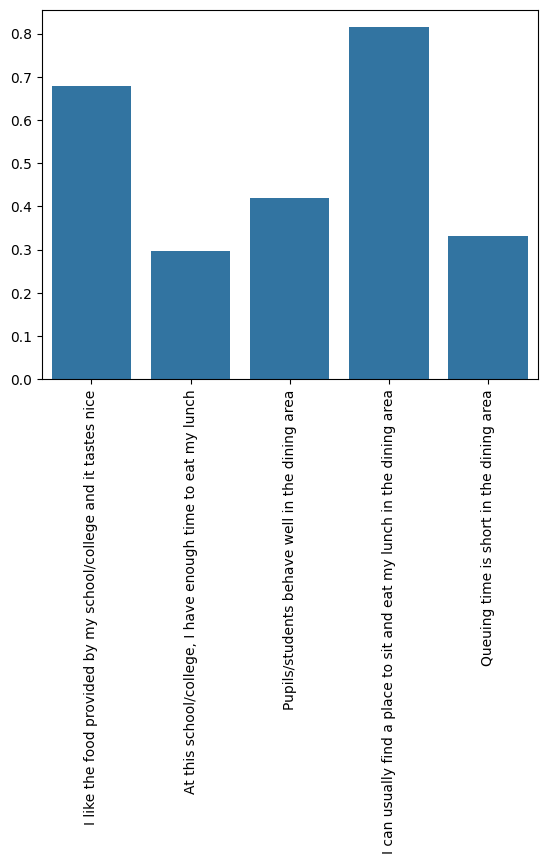

In [29]:
fig, ax = plt.subplots()
sns.barplot(x=X.columns.tolist(), y=model.coef_[0])
ax.tick_params(rotation=90, axis="x")

Having a place to sit is the most important feature in predicting enjoyment of eating lunch at school. Let us find the number of people who say they don't enjoy eating lunch at school and also cannot find a place to sit.

Text(0.5, 80.7222222222222, 'I can usually find a place to sit and eat my lunch\nin the dining area')

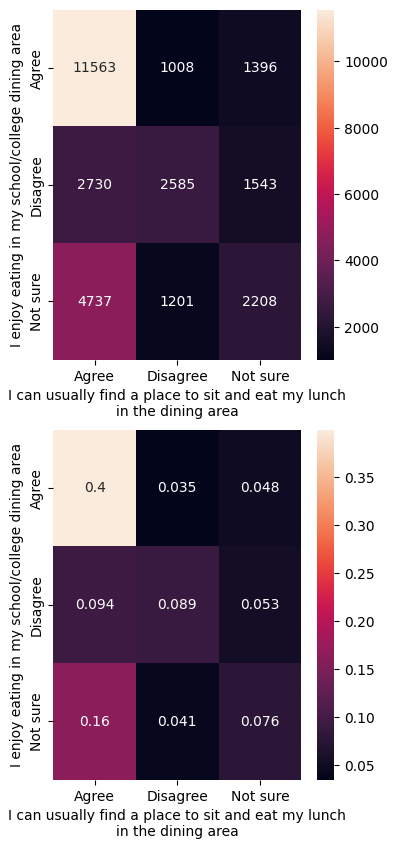

In [30]:
columns = [
    "I enjoy eating in my school/college dining area",
    "I can usually find a place to sit and eat my lunch in the dining area",
]

tmp = (
    df_lunch.droplevel("header_1", axis=1)[columns]
    .value_counts()
    .reset_index(name="Count")
    .pivot(
        index=columns[0],
        columns=columns[1],
        values="Count"
    )
)
fig, ax = plt.subplots(2, 1, figsize=(4, 10))
sns.heatmap(tmp, annot=True, fmt=".0f", ax=ax[0])
sns.heatmap(tmp / tmp.sum().sum(), annot=True, ax=ax[1])

ax[0].set_xlabel(textwrap.fill(columns[1], width=50))
ax[1].set_xlabel(textwrap.fill(columns[1], width=50))

Approximately 40% of students who said they enjoy eating in the dining area also said they could usually find a place to sit.

# 4 Quick Starting Points for Further Analysis

This section covers some areas where you may want to start your analysis. We encourage you to find something that you want to explore but this section may give a starting point.

Find the proportion of missing values in each column.

Text(0, 0.5, 'Proportion of Missing Values')

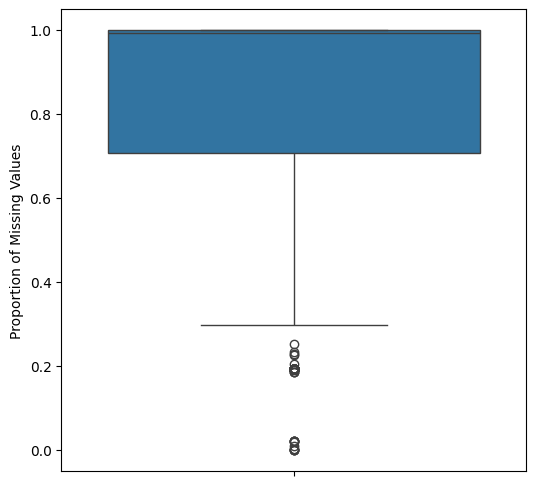

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.boxplot(df.isna().mean(axis=0))
ax.set_ylabel("Proportion of Missing Values")

There are a lot of columns where the data is completely missing:

* Are there certain topics for which the data is always missing?
* Are there patterns to when we find missing data? For example are certain questions only asked to certain age groups? 
* Is there less missing data in previous years?

Find the number of times students get 30 minutes of physical activity per week.

Text(0, 0.5, 'Number of students')

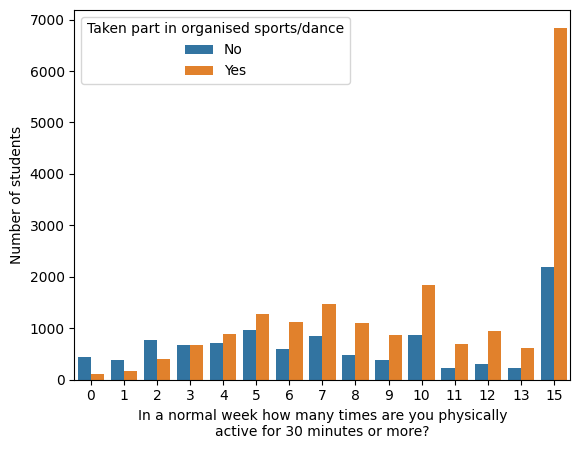

In [32]:
header_1 = "In the last four weeks, not through school/college, which of the following activities have you done?"
col1 = "Taken part in organised sports/dance (e.g. football, rugby, cricket, dance, Zumba, gymnastics, cycling, martial arts)"
col2 = "In a normal week how many times are you physically active for 30 minutes or more?"

tmp = (
    df.droplevel("header_1", axis=1)[[col1, col2]]
    .replace({"14 or more": 15, "0 (Never)": 0})
    .dropna()
    .value_counts()
    .reset_index(name="Count")
    .rename(columns={col1: "Taken part in organised sports/dance"})
)
tmp[col2] = tmp[col2].astype("int")

fig, ax = plt.subplots()
sns.barplot(
    tmp,
    x=col2,
    y="Count",
    hue="Taken part in organised sports/dance"
)
ax.set_xlabel(textwrap.fill(col2, width=50))
ax.set_ylabel("Number of students")

Students who have taken in organised sports or dance tend to be more physically active.

* Why might a student not take part in organised sport/dance?
* What barriers might affect a student getting involed in organised sport or dance?
* Has the amount of physical acticity that students are getting increased or decreased over the last few years?

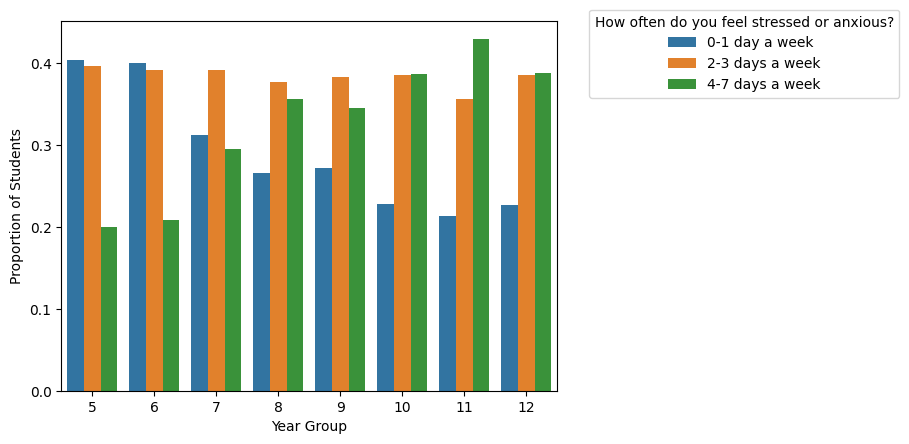

In [33]:
header_1 = "How often do you feel the following?"
header_2 = "Stressed or anxious"
col1 = df.xs(header_1, axis=1, level="header_1")[header_2]

header_1 = "No Group"
header_2 = "questionnaire_login_year_group_name"
col2 = df.xs(header_1, axis=1, level="header_1")[header_2]

tmp = pd.DataFrame([col1, col2]).transpose()

col1 = "questionnaire_login_year_group_name"
col2 = "Stressed or anxious"
tmp = (
    tmp.groupby(col1)
    .value_counts(normalize=True)
    .reset_index(name="Count")
    .replace({
        "Rarely/Never (0-1 day a week)": "0-1 day a week",
        "Some days (2-3 days a week)": "2-3 days a week",
        "Every day/Most Days (4-7 days a week)": "4-7 days a week"
    })
)
tmp[col1] = tmp[col1].str.split(" ").str[-1].astype("int")

fig, ax = plt.subplots()
sns.barplot(tmp, x="questionnaire_login_year_group_name", y="Count", hue="Stressed or anxious")
ax.set_xlabel("Year Group")
ax.set_ylabel("Proportion of Students")
ax.legend(
    title="How often do you feel stressed or anxious?",
    bbox_to_anchor=(1.05, 1.05)
)

Students in higher year groups report they feel stressed or anxious much more often than students in lower year groups.

* Are there years when students feel more or less stressed?
* Are there any common traits amongst students who say they do not feel regularly?